In [1]:
import os
import os.path

from collections import OrderedDict

import torch
from torch import nn, optim

import numpy as np

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import datasets
from skimage import io

import pickle

from utils import *

In [5]:
class FashionMNIST(Dataset):
    
    img_shape = (1, 28, 28)
    classes = [
        'T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot',
    ]
    
    def __init__(self, folder, batch_size=32, num_workers=0, val_size=.2, seed=123):
        self.folder = folder
        
        train = datasets.FashionMNIST(folder, train=True, download=True)
        test = datasets.FashionMNIST(folder, train=False, download=True)
        
        data = torch.cat([
            train.train_data.unsqueeze(1).float() / 255.,
            test.test_data.unsqueeze(1).float() / 255.,
        ])
        
        labels = torch.cat([
            train.train_labels, test.test_labels
        ]).numpy()
        
        train_val_size = len(train)
        test_size = len(data) - train_val_size
        
        self.seed = seed
        rs = np.random.RandomState(seed)
        train_val = np.arange(train_val_size)
        rs.shuffle(train_val)
        
        test = np.arange(train_val_size, len(data))
        
        dataset_size = len(data)
        idx = np.arange(dataset_size)

        train_val_size = len(train_val)

        train_size = int(round(train_val_size * (1 - val_size)))
        val_size = train_val_size - train_size
        train, val = train_val[:train_size], train_val[train_size:]

        train_sampler = sampler.SubsetRandomSampler(train)
        val_sampler = sampler.SubsetRandomSampler(val)
        train_val_sampler = sampler.SubsetRandomSampler(train_val)
        test_sampler = sampler.SubsetRandomSampler(test)

        train_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
        val_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)
        train_val_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=train_val_sampler)
        test_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler)

        num_classes = len(self.classes)
        
        for k, v in locals().items():
            setattr(self, k, v)
        
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]
        cls = self.classes[y]
        
        return X, y, cls

In [6]:
dataset = FashionMNIST(os.path.join('data', 'fashionMNIST'))

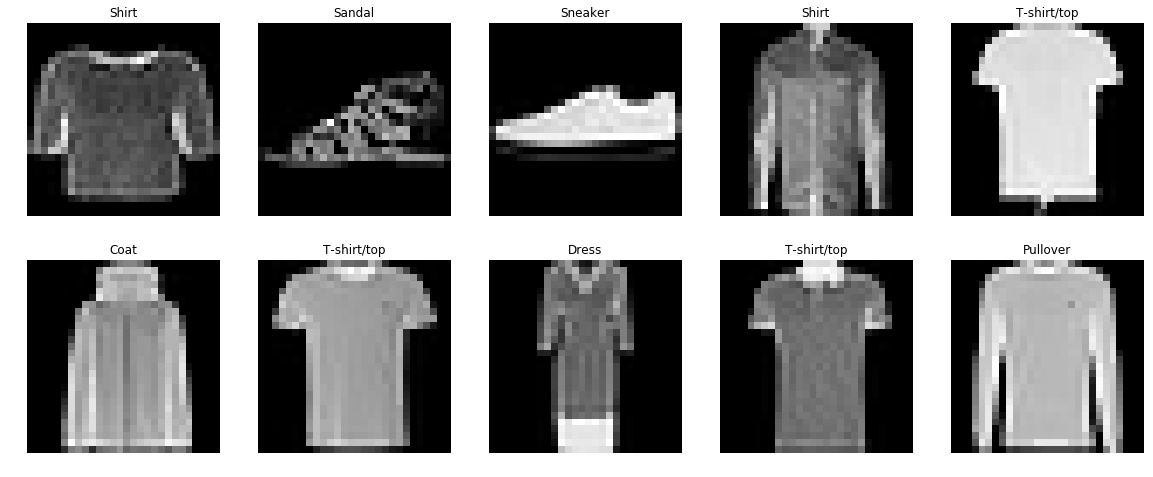

In [7]:
axes = subplots(2, 5).flatten()

for ax in axes:
    idx = np.random.choice(dataset.train_size)
    im, _, label = dataset[dataset.train[idx]]
    imshow(im, ax, title=label)